# Creating our own dataset from Johns Hopkins COVID Dataset

In [1]:
import numpy as np
import pandas as pd
import os, sys, json
import matplotlib
from matplotlib import pyplot as plt

We are interested in analyzing the `.csv` files compiled and provided by the Johns Hopkins University, that can be [accessed here](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases). There are 6 different files to analyze: `time_series_2019-ncov-Confirmed.csv`, `time_series_2019-ncov-Recovered.csv`, `time_series_2019-ncov-Deaths.csv`, `time_series-ncov-Confirmed.csv`, `time_series-ncov-Recovered.csv` and `time_series-ncov-Deaths.csv`. As their name says, there are two different styles of file, and we also need to understand what changes between them.

The files are downloaded into the `data/` folder.

In [2]:
datapath = '../data'
ts_2019_deaths = pd.read_csv(f'{datapath}/time_series_2019-ncov-Deaths.csv')
ts_2019_recov = pd.read_csv(f'{datapath}/time_series_2019-ncov-Recovered.csv')
ts_2019_conf = pd.read_csv(f'{datapath}/time_series_2019-ncov-Confirmed.csv')

ts_deaths = pd.read_csv(f'{datapath}/time_series-ncov-Deaths.csv')
ts_recov = pd.read_csv(f'{datapath}/time_series-ncov-Recovered.csv')
ts_conf = pd.read_csv(f'{datapath}/time_series-ncov-Confirmed.csv')

ts_n_deaths = pd.read_csv(f'{datapath}/time_series_covid19_deaths_global_narrow.csv')
ts_n_recov = pd.read_csv(f'{datapath}/time_series_covid19_recovered_global_narrow.csv')
ts_n_conf = pd.read_csv(f'{datapath}/time_series_covid19_confirmed_global_narrow.csv')

Lets look into the the Confirmed cases file of the pattern that contains `2019` in the name:

In [3]:
ts_2019_conf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,82,114,147,177,212,272,322,411,599,599.0
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,773,839,825,878,889,924,963,1007,1086,1086.0
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,212,226,243,266,313,345,385,432,455,455.0
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,2,2.0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,238,428,566,673,790,900,1030,1183,1306,1306.0


We can realize that some columns refer to the identification of the entity, with information such as the name of the country and its latitude and longitude. The rest of the columns refer to every day since January 22, 2020. By generalization, we will assume that the other two files of this pattern have the same column style.

Lets now look what changes between the patterns by looking into the second:

In [4]:
ts_conf.head()

,Province/State,Country/Region,Lat,Long,Date,Value
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+infected+value+num
1,NaN,Afghanistan,33.0,65.0,2020-03-23,40
2,NaN,Afghanistan,33.0,65.0,2020-03-22,40
3,NaN,Afghanistan,33.0,65.0,2020-03-21,24
4,NaN,Afghanistan,33.0,65.0,2020-03-20,24


Besides the first row, which seems to be a header, we now have the same information structured differently: each row represents a day in a Country or a Province, and the `Value` column represents the number of Confirmed cases in that day. Considering that we want to extract the number of Confirmed, Recovered and Death cases, this last structure configuration is more interesting.

Lets look into a Country to confirm that the days have the same range:

In [5]:
ts_conf[ts_conf['Country/Region'] == 'Afghanistan']

,Province/State,Country/Region,Lat,Long,Date,Value
1,NaN,Afghanistan,33.0,65.0,2020-03-23,40
2,NaN,Afghanistan,33.0,65.0,2020-03-22,40
3,NaN,Afghanistan,33.0,65.0,2020-03-21,24
4,NaN,Afghanistan,33.0,65.0,2020-03-20,24
5,NaN,Afghanistan,33.0,65.0,2020-03-19,22
...,...,...,...,...,...,...
58,NaN,Afghanistan,33.0,65.0,2020-01-26,0
59,NaN,Afghanistan,33.0,65.0,2020-01-25,0
60,NaN,Afghanistan,33.0,65.0,2020-01-24,0
61,NaN,Afghanistan,33.0,65.0,2020-01-23,0


Since the days also range from January 22, 2020 to March 23, 2020, they are perfect to use.

### UPDATE

A few days after we first did this, the Johns Hopkins University stoped releasing the second pattern of datasets and started releasing a third pattern. Lets take a peek into the ts_n pattern to check if they have the same features.

In [6]:
ts_n_conf.head()

,Province/State,Country/Region,Lat,Long,Date,Value
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+infected+value+num
1,NaN,Afghanistan,33.0,65.0,2020-04-01,237
2,NaN,Afghanistan,33.0,65.0,2020-03-31,174
3,NaN,Afghanistan,33.0,65.0,2020-03-30,170
4,NaN,Afghanistan,33.0,65.0,2020-03-29,120


We have now confirmed that they do have the same features, and we must start using the ts_n dataframes to generate the json data.

## Creating our own dataset

We'll now rename the `Value` column to `Confirmed` and append the `Value` column of both Deaths and Recovered DataFrames into the Confirmed df and then remove the first line:

In [7]:
new_columns = list(ts_n_conf.columns)[:-1] + ['Confirmed']
ts_n_conf.columns = new_columns
ts_n_conf.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+infected+value+num
1,NaN,Afghanistan,33.0,65.0,2020-04-01,237
2,NaN,Afghanistan,33.0,65.0,2020-03-31,174
3,NaN,Afghanistan,33.0,65.0,2020-03-30,170
4,NaN,Afghanistan,33.0,65.0,2020-03-29,120


In [8]:
ts_n_recov.head()

,Province/State,Country/Region,Lat,Long,Date,Value
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+infected+value+num
1,NaN,Afghanistan,33.0,65.0,2020-04-01,5
2,NaN,Afghanistan,33.0,65.0,2020-03-31,5
3,NaN,Afghanistan,33.0,65.0,2020-03-30,2
4,NaN,Afghanistan,33.0,65.0,2020-03-29,2


In [9]:
ts_all = ts_n_conf.copy()
ts_all['Recovered'] = ts_n_recov['Value']
ts_all['Deaths'] = ts_n_deaths['Value']
ts = ts_all.loc[1:]
ts = ts.fillna(0)

In [10]:
ts = ts.astype({ 'Confirmed': 'int', 'Recovered': 'int', 'Deaths': 'int' })

In [11]:
ts_all.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Recovered,Deaths
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+infected+value+num,#affected+infected+value+num,#affected+infected+value+num
1,NaN,Afghanistan,33.0,65.0,2020-04-01,237,5,4
2,NaN,Afghanistan,33.0,65.0,2020-03-31,174,5,4
3,NaN,Afghanistan,33.0,65.0,2020-03-30,170,2,4
4,NaN,Afghanistan,33.0,65.0,2020-03-29,120,2,4


In [12]:
ts.to_csv(f'{datapath}/covid_data.csv')

Now we need to structure the data in an useful way to manipulate it when creating our visualization. For that, it is interesting to remove the province identification and keep the identification by Country and Date. Therefore, we are grouping the data by Country and Date, and the value in the Confirmed, Recovered and Death will be the sum of the values in each province.

For example, if in February 1st we had the rows:
```
USA - Arizona - 21 Confirmed - 0 Recovered - 0 Deaths,
USA - California - 97 Confirmed - 1 Recovered - 3 Deaths,
USA - Idaho - 2 Confirmed - 0 Recovered - 0 Deaths,
USA - Texas - 210 Confirmed - 5 Recovered - 2 Deaths
```

The result of the groupby would be:
```
USA - 330 Confirmed - 6 Recovered - 5 Deaths
```

In [13]:
ts_grouped = ts.groupby(['Country/Region', 'Date']).agg({ 'Confirmed': 'sum', 'Recovered': 'sum', 'Deaths': 'sum' })
ts_grouped.head()

Confirmed  Recovered  Deaths
Country/Region Date                                    
Afghanistan    2020-01-22          0          0       0
               2020-01-23          0          0       0
               2020-01-24          0          0       0
               2020-01-25          0          0       0
               2020-01-26          0          0       0

Now we will generate our json using the data we have previously seen:

In [14]:
countries = ts['Country/Region'].unique()
covid_jsons = []

In [15]:
for country in countries:
    ts_segment = ts[ts['Country/Region'] == country].copy().reset_index()
    ts_grouped_segment = ts_grouped.loc[country].reset_index()
    
    covid_json = {
        'country': country,
        'latitude': ts_segment.loc[0]['Lat'],
        'longitude': ts_segment.loc[0]['Long'],
        'dates': ts_grouped_segment['Date'].tolist(),
        'confirmed': ts_grouped_segment['Confirmed'].tolist(),
        'deaths': ts_grouped_segment['Deaths'].tolist(),
        'recovered': ts_grouped_segment['Recovered'].tolist()
    }
    covid_jsons.append(covid_json)

In [16]:
with open(f'{datapath}/covid_data.json', 'w') as json_path:
    json.dump(covid_jsons, json_path)

### Quick problem when creating the map

When we first created the map in the `Generating Map` notebook, some of the countries such as the US have not appeared in the map. The probable cause of this problem is a wrong mapping between the keys in the json we just generated and the name that exists in the `.shp` file. Lets see if it is the case:

In [17]:
def load_shp_countries():
    fname = 'plane_countries.ndjson'
    with open(f'{datapath}/{fname}', 'r') as ndjson:
        lines = ndjson.readlines()
        
    countries = []
    for line in lines:
        jsline = json.loads(line)
        ci = jsline['properties']['COUNTRY']
        countries.append(ci)
    c_set = set(countries)
    return c_set

In [18]:
shp_countries = load_shp_countries()
country_set = set(countries.tolist())

In [19]:
diff1 = list(country_set - shp_countries.intersection(country_set))
diff1.sort()

diff2 = list(shp_countries - shp_countries.intersection(country_set))
diff2.sort()

In [20]:
print("; ".join(diff1))
print()
print("; ".join(diff2))

Burma; Cabo Verde; Congo (Brazzaville); Congo (Kinshasa); Cote d'Ivoire; Czechia; Diamond Princess; Eswatini; Holy See; Korea, South; Kosovo; MS Zaandam; North Macedonia; Saint Kitts and Nevis; Saint Lucia; Saint Vincent and the Grenadines; Taiwan*; Timor-Leste; US; West Bank and Gaza

American Samoa (US); American Virgin Islands (US); Anguilla (UK); Antarctica; Aruba (Netherlands); Baker Island (US); Bermuda (UK); Bonaire (Netherlands); Bouvet Island (Norway); British Indian Ocean Territory (UK); British Virgin Islands(UK); Cape Verde; Cayman Islands (UK); Christmas Island (Australia); Cocos (Keeling) Islands (Australia); Comoros; Congo; Cook Islands (New Zealand); Curacao (Netherlands); Czech Republic; Democratic Republic of the Congo; East Timor; Falkland Islands (UK); Faroe Islands (Denmark); Federated States of Micronesia; French Guiana (France); French Polynesia (France); French Southern & Antarctic Lands (France); Gibraltar (UK); Glorioso Islands (France); Greenland (Denmark); G

Since our assumption was correct, we now need to map (using human knowledge and the internet to prevent mismatches) the country names in the country set to the names in the shp set:

In [21]:
mapping = {
    'Congo (Brazzaville)': 'Congo',
    'Congo (Kinshasa)': 'Democratic Republic of the Congo',
    'Cote d\'Ivoire': 'Ivory Coast',
    'Czechia': 'Czech Republic',
    'French Guiana': 'French Guiana (France)',
    'Greenland': 'Greenland (Denmark)',
    'Guadeloupe': 'Guadeloupe (France)',
    'Guam': 'Guam (US)',
    'Guernsey': 'Guernsey (UK)',
    'Jersey': 'Jersey (UK)',
    'Korea, South': 'South Korea',
    'Martinique': 'Martinique (France)',
    'Mayotte': 'Mayotte (France)',
    'North Macedonia': 'Macedonia',
    'Puerto Rico': 'Puerto Rico (US)',
    'Reunion': 'Reunion (France)',
    'Saint Lucia': 'St. Lucia',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    'Taiwan*': 'Taiwan',
    'The Bahamas': 'Bahamas',
    'The Gambia': 'Gambia',
    'US': 'United States'
}

In [22]:
covid_jsons = []
for country in countries:
    ts_segment = ts[ts['Country/Region'] == country].copy().reset_index()
    ts_grouped_segment = ts_grouped.loc[country].reset_index()
    
    covid_json = {
        'country': mapping[country] if country in mapping else country,
        'latitude': ts_segment.loc[0]['Lat'],
        'longitude': ts_segment.loc[0]['Long'],
        'dates': ts_grouped_segment['Date'].tolist(),
        'confirmed': ts_grouped_segment['Confirmed'].tolist(),
        'deaths': ts_grouped_segment['Deaths'].tolist(),
        'recovered': ts_grouped_segment['Recovered'].tolist()
    }
    covid_jsons.append(covid_json)

In [23]:
with open(f'{datapath}/covid_updated.json', 'w') as json_path:
    json.dump(covid_jsons, json_path)

## Data Visualizations

In [24]:
brazil = ts[ts['Country/Region'] == 'Brazil'].reset_index(drop=True)
brazil = brazil.reindex(index=brazil.index[::-1])

In [25]:
brazil.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Recovered,Deaths
70,0,Brazil,-14.235,-51.9253,2020-01-22,0,0,0
69,0,Brazil,-14.235,-51.9253,2020-01-23,0,0,0
68,0,Brazil,-14.235,-51.9253,2020-01-24,0,0,0
67,0,Brazil,-14.235,-51.9253,2020-01-25,0,0,0
66,0,Brazil,-14.235,-51.9253,2020-01-26,0,0,0


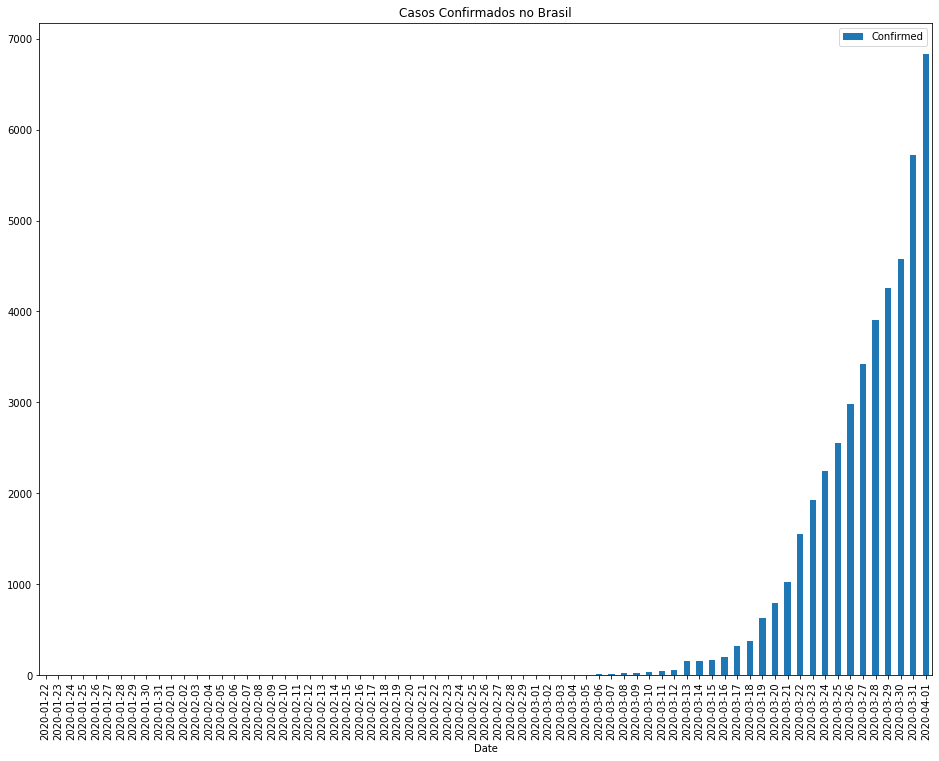

In [26]:
brazil.plot.bar(x='Date', y='Confirmed', title='Casos Confirmados no Brasil', figsize=(16, 12))

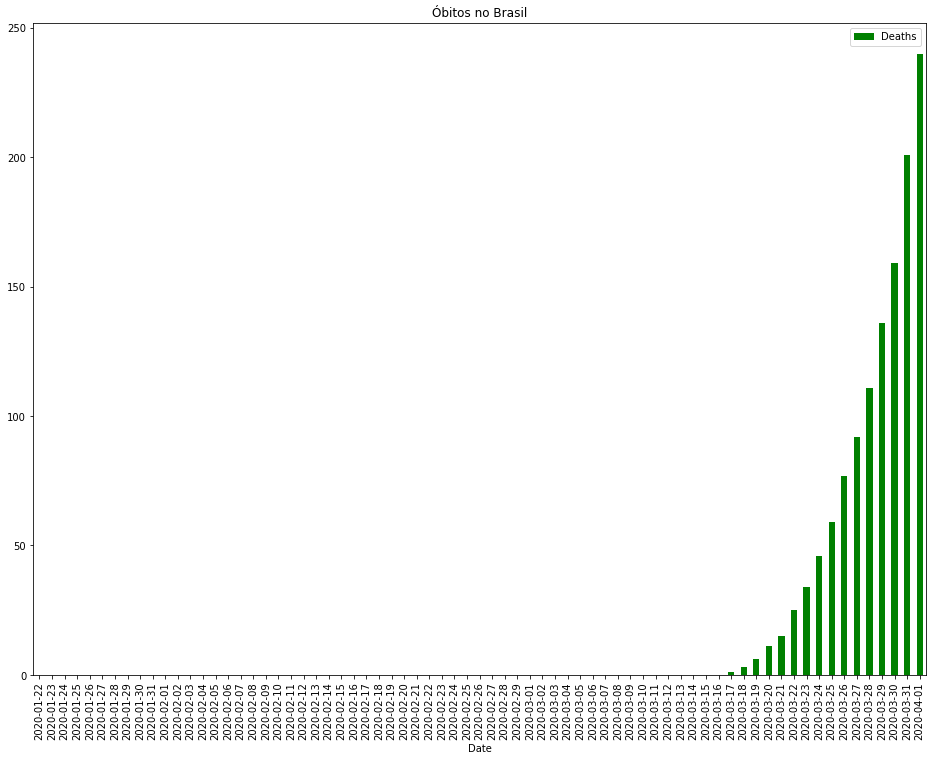

In [27]:
brazil.plot.bar(x='Date', y='Deaths', title='Óbitos no Brasil', figsize=(16, 12), color='green')

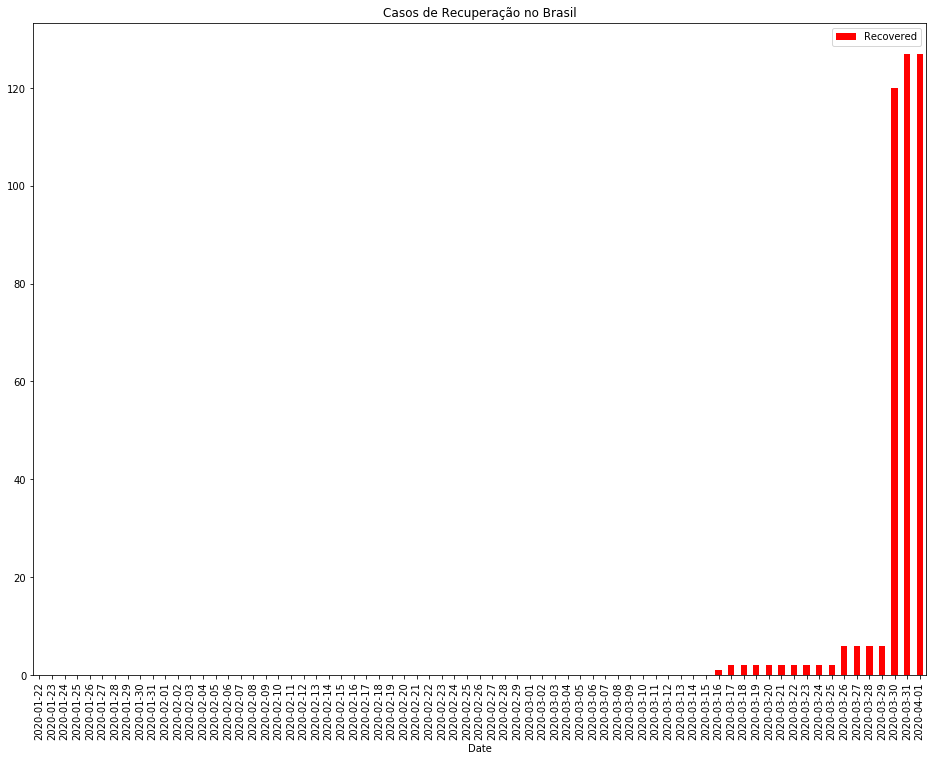

In [28]:
brazil.plot.bar(x='Date', y='Recovered', title='Casos de Recuperação no Brasil', figsize=(16, 12), color='red')

We will now generate the data for replicating these plots using d3js.

In [30]:
chart_json = {}
daily_data = {}

for country in countries:
    segment = ts[ts['Country/Region'] == country]
    daily = []
    for index, row in segment.iterrows():
        daily.append({
            'date': row['Date'],
            'confirmed': row['Confirmed'],
            'deaths': row['Deaths'],
            'recovered': row['Deaths']
        })
        
        if row['Date'] in daily_data:
            daily_data[row['Date']]['confirmed'] += row['Confirmed']
            daily_data[row['Date']]['deaths'] += row['Deaths']
            daily_data[row['Date']]['recovered'] += row['Recovered']
        else:
            daily_data[row['Date']] = {
                'confirmed': row['Confirmed'],
                'deaths': row['Deaths'],
                'recovered': row['Recovered']
            }
    
    country_name = mapping[country] if country in mapping else country
    chart_json[country_name] = {
        'country': country_name,
        'data': daily
    }


world_data = []
for key in daily_data.keys():
    daily_data[key]['date'] = key
    world_data.append(daily_data[key])
world_obj = {
    'country': 'World',
    'data': world_data
}
chart_json['World'] = world_obj

In [32]:
with open(f'{datapath}/covid_chart.json', 'w') as covid_chart:
    json.dump(chart_json, covid_chart)